## 머신러닝 알고리즘 적용 _ 심화
    - 데이터 : 사용자 데이터 + 상품 데이터(과거 상품 구매 이력)
    - 신규 모델 : RandomForest, ExtraTrees, BaggingClassifier, (XGBoost)
    - 업데이트된 데이터 + 기존 모델(DT, LR) 평가척도 
    - 업데이트된 데이터 + 신규 모델 평가척도
    - [+2] 피쳐 엔지니어링
    - [+2] 매개변수 조정
    - 캐글 제출 
    - 머신러닝 파이프라인 흐름도 기록

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import operator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss, f1_score, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# 신규 데이터 로딩

trn = pd.read_csv('../input/train_append_lb_lag.csv').fillna(0)
target = pd.DataFrame(pickle.load(open('../input/target.pkl','rb')), columns=['target'])
tst = pd.read_csv('../input/test_append_lb_lag.csv').fillna(0)
print(trn.shape, target.shape, tst.shape)

(45619, 246) (45619, 1) (929615, 246)


In [3]:
# 신규 데이터 설명
for col in trn.columns:
    print(col)

age
antiguedad
canal_entrada
cod_prov
conyuemp
fecha_alta
ind_actividad_cliente
ind_empleado
ind_nuevo
indext
indfall
indrel
indrel_1mes
indresi
nomprov
pais_residencia
renta
segmento
sexo
tiprel_1mes
ult_fec_cli_1t
age_lag_one
antiguedad_lag_one
canal_entrada_lag_one
cod_prov_lag_one
conyuemp_lag_one
fecha_alta_lag_one
ind_actividad_cliente_lag_one
ind_ahor_fin_ult1_lag_one
ind_aval_fin_ult1_lag_one
ind_cco_fin_ult1_lag_one
ind_cder_fin_ult1_lag_one
ind_cno_fin_ult1_lag_one
ind_ctju_fin_ult1_lag_one
ind_ctma_fin_ult1_lag_one
ind_ctop_fin_ult1_lag_one
ind_ctpp_fin_ult1_lag_one
ind_deco_fin_ult1_lag_one
ind_dela_fin_ult1_lag_one
ind_deme_fin_ult1_lag_one
ind_ecue_fin_ult1_lag_one
ind_empleado_lag_one
ind_fond_fin_ult1_lag_one
ind_hip_fin_ult1_lag_one
ind_nom_pens_ult1_lag_one
ind_nomina_ult1_lag_one
ind_nuevo_lag_one
ind_plan_fin_ult1_lag_one
ind_pres_fin_ult1_lag_one
ind_reca_fin_ult1_lag_one
ind_recibo_ult1_lag_one
ind_tjcr_fin_ult1_lag_one
ind_valo_fin_ult1_lag_one
ind_viv_fin_ult1_l

In [4]:
# 훈련 데이터와 테스트 데이터 동일 여부 확인
trn.columns == tst.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [5]:
# 빈도가 낮은 타겟은 사전에 제거 (이유: 교차 검증에 활용할 수 없음 + 너무 빈도가 낮아 무의미함)
rem_targets = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23]  # 18 classes
trn = trn[target['target'].isin(rem_targets)]
target = target[target['target'].isin(rem_targets)]
target = LabelEncoder().fit_transform(target)

for t in np.unique(target):
    print(t, sum(target==t))

C:\Users\moonhwi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0 9452
1 1934
2 55
3 349
4 222
5 154
6 503
7 33
8 1085
9 1219
10 246
11 21
12 2942
13 4733
14 159
15 5151
16 8218
17 9119


## 평가용 함수 정의

In [6]:
def evaluate(x, y, model):
    trn_scores = dict(); vld_scores = dict()
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=777)
    for t_ind, v_ind in sss.split(x,y):
        # split data
        x_trn, x_vld = x.iloc[t_ind], x.iloc[v_ind]
        y_trn, y_vld = y[t_ind], y[v_ind]

        # fit model
        model.fit(x_trn, y_trn)
        
        # eval _ trn        
        preds = model.predict_proba(x_trn)

        log_scores = trn_scores.get('log loss', [])
        log_scores.append(log_loss(y_trn, preds))
        trn_scores['log loss'] = log_scores

        # eval _ vld
        preds = model.predict_proba(x_vld)

        log_scores = vld_scores.get('log loss', [])
        log_scores.append(log_loss(y_vld, preds))
        vld_scores['log loss'] = log_scores
    return trn_scores, vld_scores

def print_scores(trn_scores, vld_scores):
    prefix = '        '
    cols = ['log loss']
    print('='*50)
    print('TRAIN EVAL')
    for col in cols:
        print('-'*50)
        print('# {}'.format(col))
        print('# {} Mean : {}'.format(prefix, np.mean(trn_scores[col])))
        print('# {} Raw  : {}'.format(prefix, trn_scores[col]))

    print('='*50)
    print('VALID EVAL')
    for col in cols:
        print('-'*50)
        print('# {}'.format(col))
        print('# {} Mean : {}'.format(prefix, np.mean(vld_scores[col])))
        print('# {} Raw  : {}'.format(prefix, vld_scores[col]))

def print_time(end, start):
    print('='*50)
    elapsed = end - start
    print('{} secs'.format(round(elapsed)))
    
def fit_and_eval(trn, target, model):
    trn_scores, vld_scores = evaluate(trn,target,model)
    print_scores(trn_scores, vld_scores)
    print_time(time.time(), st)    

## 피쳐 엔지니어링 (데이터 최적화)
    - 직접 새로운 변수를 추가 혹은 기존 변수를 삭제하여서 최적의 변수세트 생성해보기
    - 주의: 훈련 데이터에 수행한 변수 변환은 테스트 데이터에도 동일하게 수행해야함
    - 힌트: 금융 상품에 대한 새로운 정보를 넣는 것

* 실험(drop test)

fecha_alta, antiguedad(drop) extraTree-?

cod_prov, nomprov(drop) extraTree+


* 미실험

tiprel_1mes의 active, inactive 관계?

age 의 첫번째 peak는 segmento의 college graduated 의 영향 -> college graduated & other model 분리 한다면?

college graduated(segmento) 가입자들의 대부분은 가입채널 KHE(canal_entrada)을 통함

소득에 따라 가입 채널이 차이가 있음 KAT(VIP) > KFC > KHE (college graduated) > other



In [7]:
# 입력 : trn, target, tst
# 출력 : new trn, new tst, same target

## 중복되는 의미의 변수 제거
trn = trn.drop(['fecha_alta'], axis = 1)
tst = tst.drop(['fecha_alta'], axis = 1)
trn = trn.drop(['nomprov'], axis = 1)
tst = tst.drop(['nomprov'], axis = 1)


In [8]:
cols = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
        'ind_cder_fin_ult1', 'ind_cno_fin_ult1',  'ind_ctju_fin_ult1',
        'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
        'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
        'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
        'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
        'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
        'ind_nomina_ult1',   'ind_nom_pens_ult1', 'ind_recibo_ult1']

print(trn.shape, tst.shape)

# 타겟별 누적 합
lags = ['_lag_one','_lag_two','_lag_thr','_lag_fou','_lag_fiv']
for col in cols:
    trn[col+'_sum'] = trn[[col+lag for lag in lags]].sum(axis=1)
    tst[col+'_sum'] = tst[[col+lag for lag in lags]].sum(axis=1)
    
# 월별 누적 합
for lag in lags:
    trn['sum'+lag] = trn[[col+lag for col in cols]].sum(axis=1)
    tst['sum'+lag] = tst[[col+lag for col in cols]].sum(axis=1)
    
print(trn.shape, tst.shape)

(45595, 244) (929615, 244)
(45595, 273) (929615, 273)


In [9]:
trn.head()

,age,antiguedad,canal_entrada,cod_prov,conyuemp,ind_actividad_cliente,ind_empleado,ind_nuevo,indext,indfall,...,ind_valo_fin_ult1_sum,ind_viv_fin_ult1_sum,ind_nomina_ult1_sum,ind_nom_pens_ult1_sum,ind_recibo_ult1_sum,sum_lag_one,sum_lag_two,sum_lag_thr,sum_lag_fou,sum_lag_fiv
0,28,34,150,20,2,1,3,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28,34,150,20,2,1,3,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,37,34,122,20,2,1,3,0,0,0,...,0.0,0.0,3.0,3.0,5.0,3.0,5.0,5.0,3.0,5.0
3,37,34,122,20,2,1,3,0,0,0,...,0.0,0.0,3.0,3.0,5.0,3.0,5.0,5.0,3.0,5.0
4,40,34,122,20,2,1,3,0,0,0,...,0.0,0.0,0.0,0.0,5.0,2.0,2.0,2.0,2.0,2.0


## 모델 학습 및 평가
    - 모델 종류
        - Decision Tree : 트리 기반 모델
        - Logistic Regression : 선형 모델
        - RandomForest, ExtraTrees : 트리 기반 앙상블 모델
        - BaggingClassifier : 앙상블 모델
        - (XGBoost) : 트리 기반 앙상블 모델
        
    - 훈련/검증 데이터 기반 평가 척도
        - Log Loss
        
    - 검증 데이터 Log Loss 목표 수치 = 1.1

## 3회차 모델

In [10]:
st = time.time()
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=180, max_depth=13, n_jobs=-1, random_state=777)
fit_and_eval(trn, target, rf_model)
# 5 sec

TRAIN EVAL
--------------------------------------------------
# log loss
#          Mean : 0.9070854458446757
#          Raw  : [0.90685283550245477, 0.90507752721081869, 0.90932597482075339]
VALID EVAL
--------------------------------------------------
# log loss
#          Mean : 1.1711367680521683
#          Raw  : [1.1596552329319356, 1.1758345528373504, 1.1779205183872188]
60 secs


In [11]:
st = time.time()
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier(n_estimators=50, max_depth=13, n_jobs=-1, random_state=777)
fit_and_eval(trn, target, et_model)
# 6 sec

TRAIN EVAL
--------------------------------------------------
# log loss
#          Mean : 0.9780373959955972
#          Raw  : [0.97842927201488938, 0.98512468065319303, 0.97055823531870944]
VALID EVAL
--------------------------------------------------
# log loss
#          Mean : 1.2000418697193418
#          Raw  : [1.1925968871957175, 1.2166055113561309, 1.1909232106061771]
16 secs


## 모델 매개변수 및 주요 변수 시각화 (1)
    - Decision Tree, RandomForest, ExtraTrees 전용

In [12]:
# Utility

def observe_model_tree(trn, model):
    print('='*50)
    print(model)
    
    print('='*50)
    print('# Feature Importance')
    print(model.feature_importances_)
    
    print('-'*50)
    print('# Mapped to Column Name')
    prefix = '    '
    feature_importance = dict()
    for i, f_imp in enumerate(model.feature_importances_):
        print('{} {} \t {}'.format(prefix, round(f_imp,5), trn.columns[i]))
        feature_importance[trn.columns[i]] = f_imp

    print('-'*50)
    print('# Sorted Feature Importance')
    feature_importance_sorted = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse=True)
    for item in feature_importance_sorted:
        print('{} {} \t {}'.format(prefix, round(item[1],5), item[0]))
    
    return feature_importance_sorted

def plot_fimp(fimp):
    x = []; y = []
    for item in fimp:
        x.append(item[0])
        y.append(item[1])

    f, ax = plt.subplots(figsize=(20, 15))
    sns.barplot(x,y,alpha=0.5)
    ax.set_title('Feature Importance for Model : Decision Tree')
    ax.set(xlabel='Column Name', ylabel='Feature Importance')

In [13]:
# 모델 상세 보기
rf_fimp = observe_model_tree(trn, rf_model)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=180, n_jobs=-1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)
# Feature Importance
[  1.55156571e-02   9.15468013e-03   5.91906717e-03   4.55004849e-03
   1.00993781e-05   1.16594454e-03   4.46013359e-05   1.27973954e-03
   7.29521526e-04   2.74600286e-06   3.07924036e-05   4.91212040e-06
   1.52345031e-05   2.32474063e-05   6.75636162e-03   6.47405058e-03
   1.30363280e-03   1.62524337e-03   5.46398929e-05   1.55512619e-02
   9.00976241e-03   8.17088897e-03   7.28056364e-03   3.07495630e-03
   8.59312987e-03   5.22628115e-03   3.31103889e-06   1.70948904e-06
   4.33549915e-02   1.81540222e-05   1.35083188e-02   3.89779458e-04
   2.70562341e-03   3.83122174e-04   3.554079

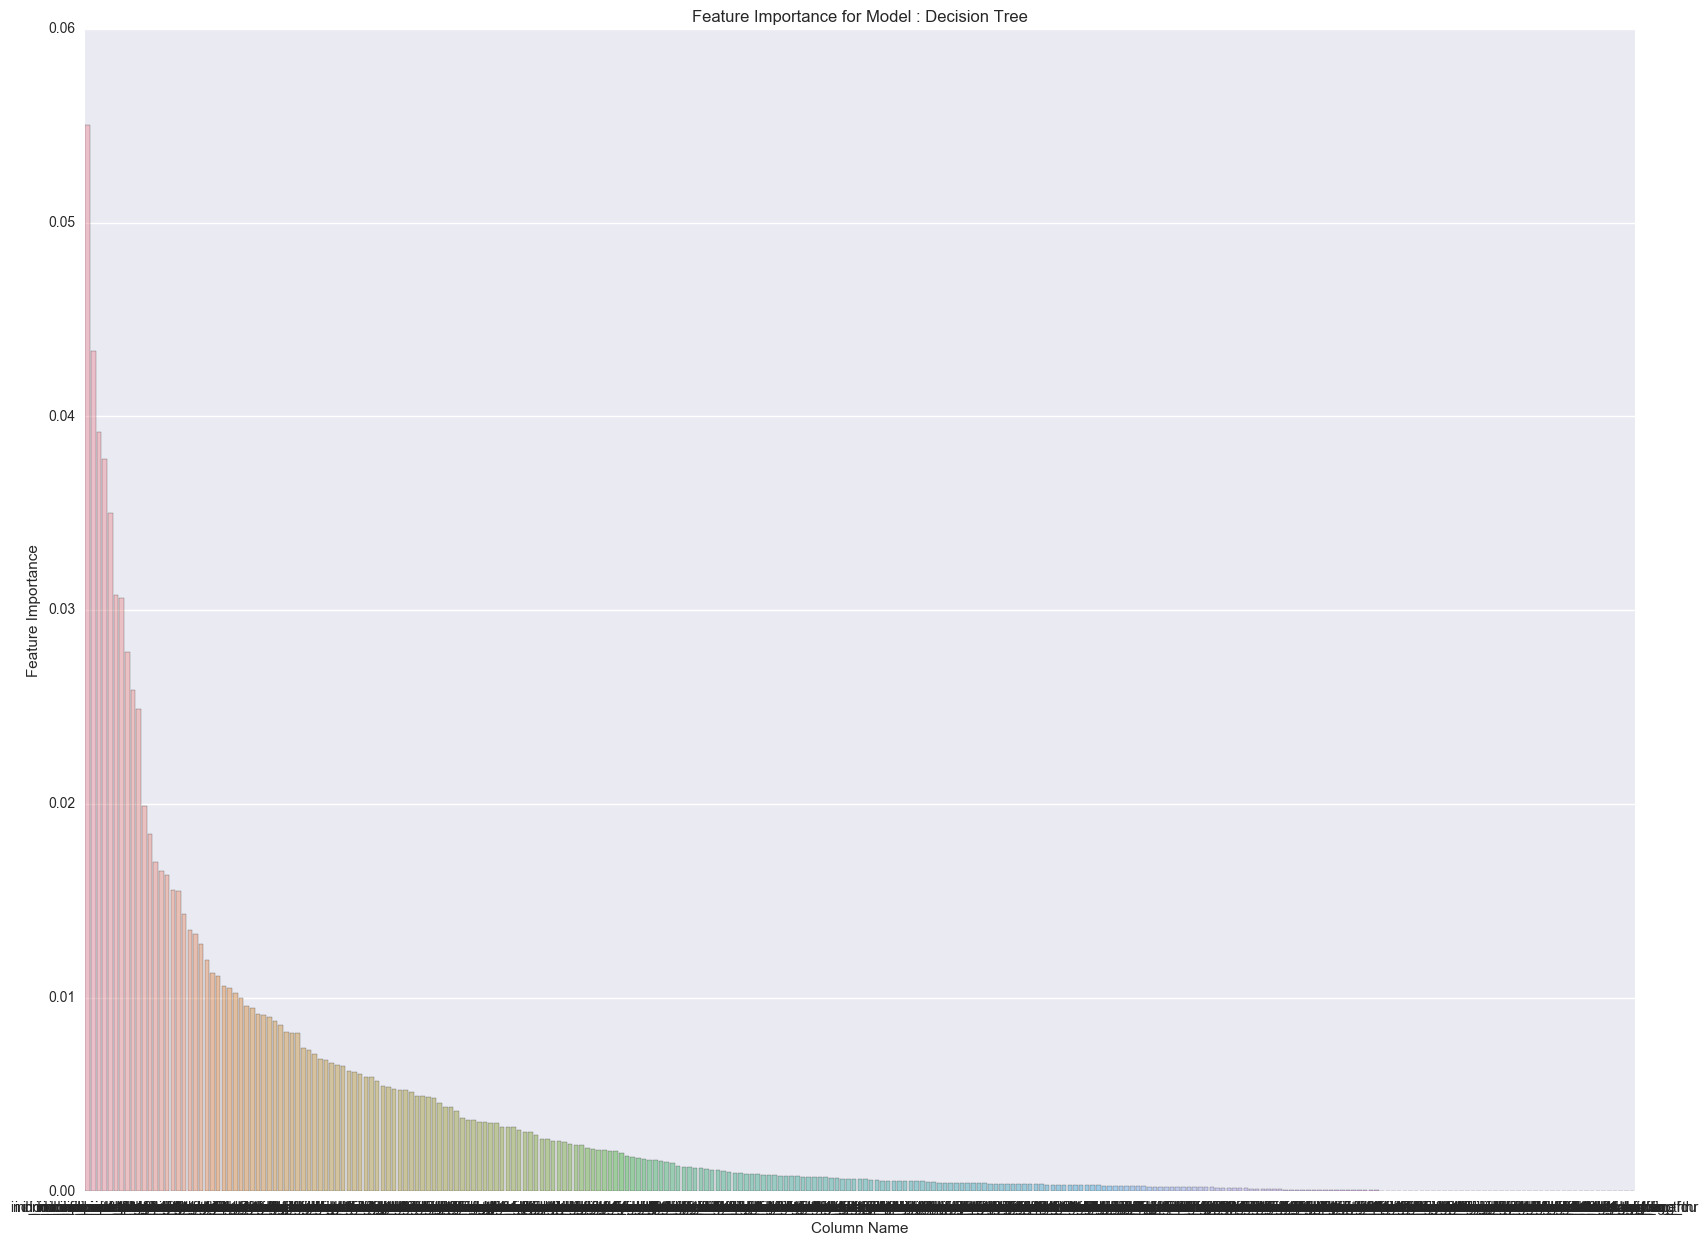

In [14]:
# 주요 변수 시각화
plot_fimp(rf_fimp)

In [15]:
# 모델 상세 보기
et_fimp = observe_model_tree(trn, et_model)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=13, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=777,
           verbose=0, warm_start=False)
# Feature Importance
[  5.80058601e-03   4.82349146e-03   2.89560373e-03   1.52693936e-03
   7.03849468e-06   1.21001742e-03   6.82776697e-05   2.13800514e-03
   7.01368994e-04   4.09173288e-06   4.19176858e-05   3.37501688e-06
   2.51619707e-05   1.68436651e-05   1.56271864e-03   4.65059206e-03
   1.04481832e-03   1.65068158e-03   3.56752305e-05   5.30315207e-03
   1.67170933e-03   5.64104931e-03   2.58466414e-03   6.23823228e-03
   2.51830187e-03   8.32880287e-03   1.93464534e-06   6.45317461e-06
   6.46460382e-02   1.37879599e-05   2.06415180e-02   9.82992847e-04
   2.71370883e-03   4.83179665e-04   4.59742451e-04 

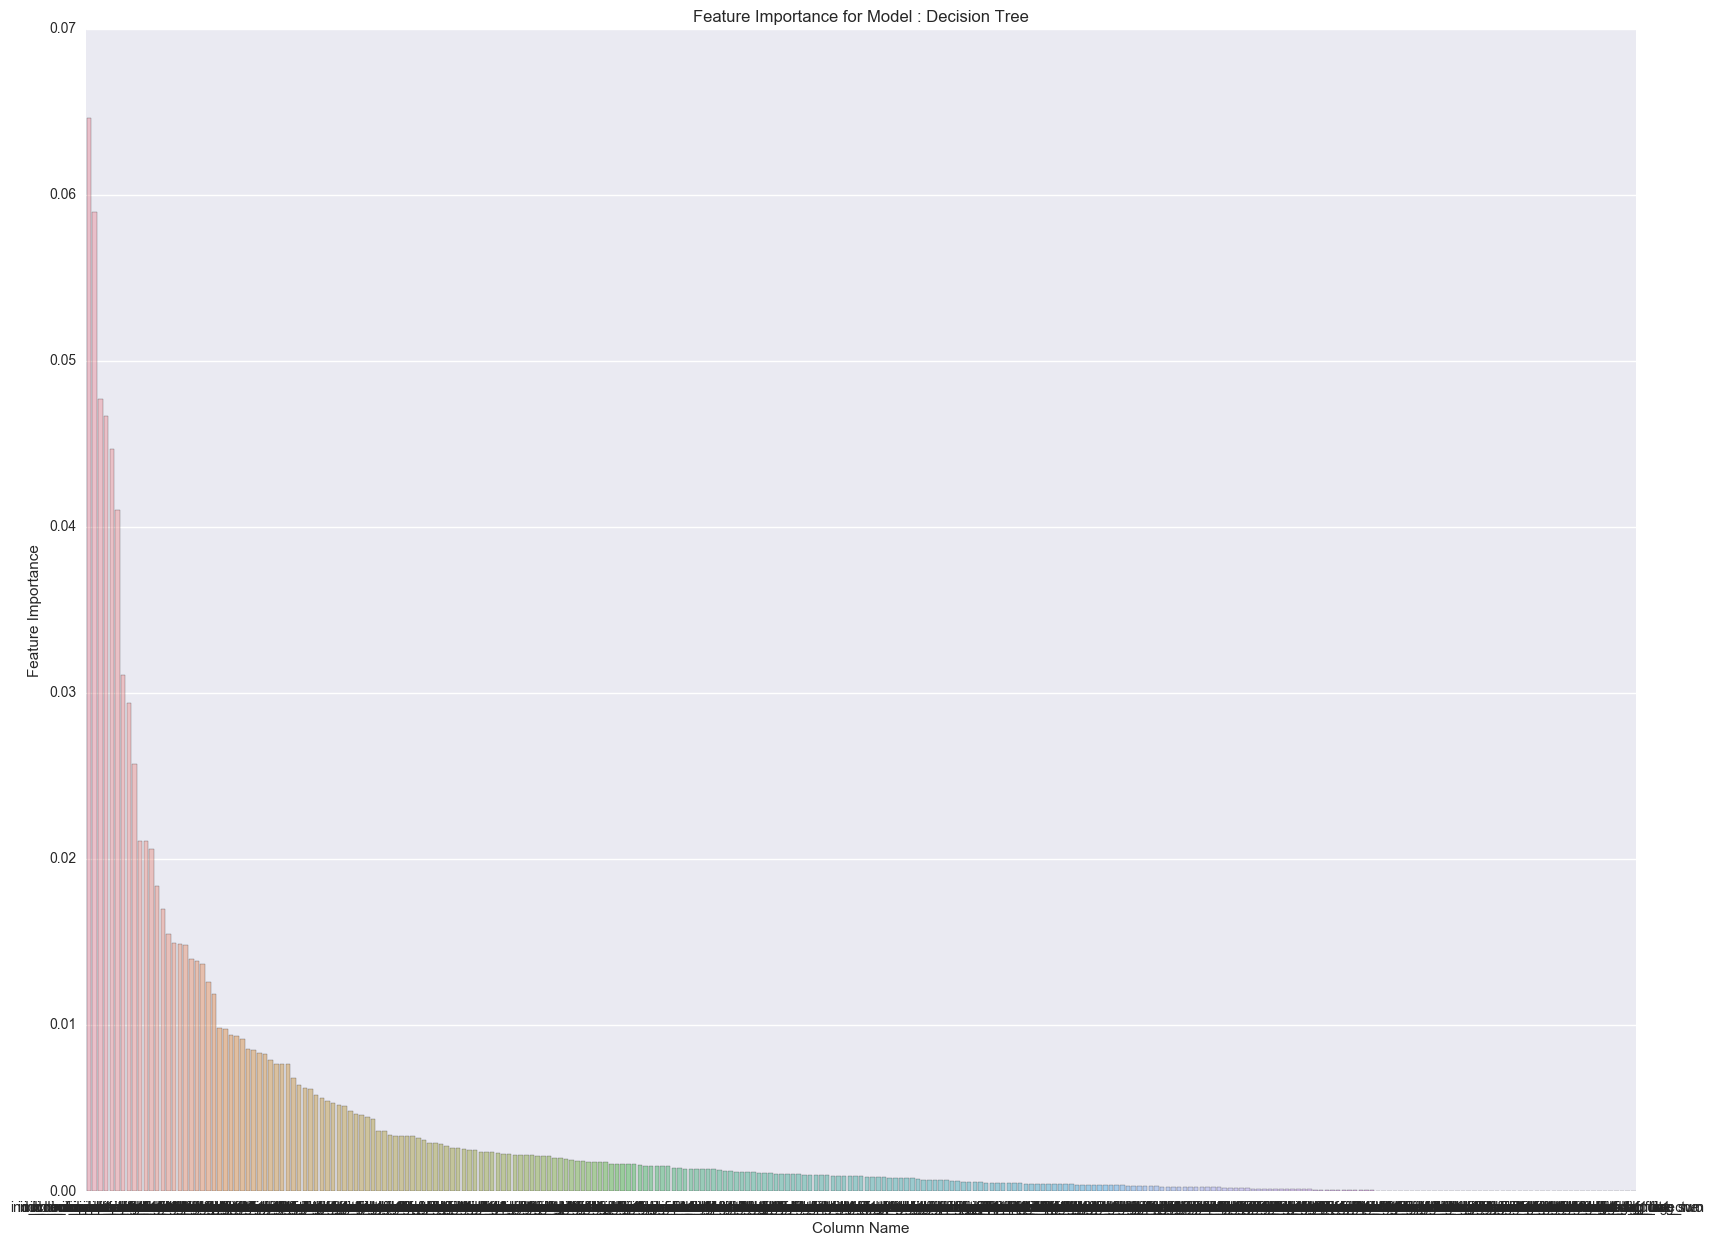

In [16]:
# 주요 변수 시각화
plot_fimp(et_fimp)

## 캐글에 직접 결과물 제출하기
    - MAP@7 평가척도를 기반 (https://www.kaggle.com/c/santander-product-recommendation/details/evaluation)
    - 유저당 상위 7개의 제품을 추천해야함

In [17]:
# 최종 모델 정의하기
model = RandomForestClassifier(n_estimators=180, max_depth=13, n_jobs=-1, random_state=777)

In [18]:
from datetime import datetime
import os

print('='*50)
print('# Test shape : {}'.format(tst.shape))

model.fit(trn,target)

preds = model.predict_proba(tst)
preds = np.fliplr(np.argsort(preds, axis=1))

# Test shape : (929615, 273)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\moonhwi\Anaconda3\lib\site-packages\sklearn\externals\joblib\_parallel_backends.py", line 344, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\moonhwi\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "C:\Users\moonhwi\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "C:\Users\moonhwi\Anaconda3\lib\site-packages\sklearn\utils\fixes.py", line 315, in parallel_helper
    return getattr(obj, methodname)(*args, **kwargs)
  File "C:\Users\moonhwi\Anaconda3\lib\site-packages\sklearn\tree\tree.py", line 768, in predict_proba
    proba = self.tree_.predict(X)
  File "sklearn\tree\_tree.pyx", line 744, in sklearn.tree._tree.Tree.predict (sklearn\tree\_tree.c:9407)
  File "sklearn\tree\_tree

TypeError: Can't convert 'list' object to str implicitly

In [ ]:
cols = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
        'ind_cder_fin_ult1', 'ind_cno_fin_ult1',  'ind_ctju_fin_ult1',
        'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
        'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
        'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
        'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
        'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
        'ind_nomina_ult1',   'ind_nom_pens_ult1', 'ind_recibo_ult1']
target_cols = [cols[i] for i, col in enumerate(cols) if i in rem_targets]

In [ ]:
final_preds = []
for pred in preds:
    top_products = []
    for i, product in enumerate(pred):
        top_products.append(target_cols[product])
        if i == 6:
            break
    final_preds.append(' '.join(top_products))

temp = pd.read_csv('../input/test_clean.csv')
test_id = temp['ncodpers']
out_df = pd.DataFrame({'ncodpers':test_id, 'added_products':final_preds})
file_name = datetime.now().strftime("result_%Y%m%d%H%M%S") + '.csv'
out_df.to_csv(os.path.join('../output',file_name), index=False)

결과물 출력은 https://www.kaggle.com/c/santander-product-recommendation/submissions/attach

## 나만의 머신러닝 파이프라인 흐름도(Flow Chart) 기록하기

- 원천 데이터
    - .

- 전처리
    - .

- 피쳐 엔지니어링 이전 데이터 dimension
    - .

- 피쳐 엔지니어링 
    - .

- 피쳐 엔지니어링 이후 데이터 dimension
    - .

- 모델 튜닝 
    - .

- 검증 결과 
    - .

- 실제 결과 
    - .

# 예시

- 원천 데이터 
    - Kaggle 경진대회 데이터 train_ver2.csv, test_ver2.csv (Link: https://www.kaggle.com/c/santander-product-recommendation/data)


- 전처리 
    - 결측값을 .fillna 함수를 통해 0으로 대체. (기존 데이터에 0이 존재할 경우 -1로 대체)


- 피쳐 엔지니어링 이전 데이터 dimension:
    - trn : (45619, 246)
    - target : (45619, 1) [18 classes]
    - tst : (929615, 246)


- 피쳐 엔지니어링
    - age_log : log(age + 1)
    - ind..._lag_one : 5월 사용자별 금융상품 보유현황
    - ind..._lag_two : 4월 사용자별 금융상품 보유현황
    - ind..._lag_thr : 3월 사용자별 금융상품 보유현황


- 피쳐 엔지니어링 이후 데이터 dimension:
    - trn : (45619, 250)
    - target : (45619, 1) [18 classes]
    - tst : (929615, 250)


- 모델 튜닝 
    - RandomForest : max_depth = 20 로 복잡도 조정


- 검증 결과 
    - trn logloss : 1.18
    - vld logloss : 1.28


- 실제 결과 
    - Public Leaderboard : 0.025984


## Appendix
    - RandomForest vs ExtraTrees 의 차이란?
        - P. Geurts, D. Ernst., and L. Wehenkel, “Extremely randomized trees”, Machine Learning, 63(1), 3-42, 2006
        - 1) ET의 경우, 변수 샘플링을 boostrap 샘플이 아닌 전체 데이터에서 취한다.
        - 2) ET의 경우, 샘플내 분포에 상관없이 완전한 임의 샘플링으로 데이터 샘플을 취한다.